# Lab 09-2: VGGNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


Prepare Datasets

In [3]:
dataset = 'imagenette'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet 
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px-v2/0.1.0.incompleteL6YMXG/imagenette-train.tfrecord


  0%|          | 0/9469 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px-v2/0.1.0.incompleteL6YMXG/imagenette-validation.tfrecord


  0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px-v2/0.1.0. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'train': <tfds.core.SplitInfo num_examples=9469>, 'validation': <tfds.core.SplitInfo num_examples=3925>}
9469


In [4]:
n_channels = ds_info.features['image'].shape[-1]

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw', 
               'church', 'French horn', 'garbage truck', 'gas pump', 
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

9469 1962 1963


Show a Sample Data

Image demension: (320, 426, 3) , label: 2


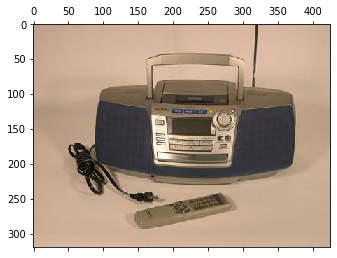


The picture is cassette player


In [5]:
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    image, label = element
    
print('Image demension:', image.shape, ', label:', label.numpy())

#dimage = tf.reshape(image, image.shape)
plt.matshow(image)
plt.show()
print('\nThe picture is', classes[label])

### Loading Pretrained Convolution Network with Keras API

In [6]:
### START CODE HERE ###

VGG16Net = tf.keras.applications.VGG16()     # use pre-trained VGG16 model

### END CODE HERE ###
    
# tf.keras.applications.vgg16.preprocess_input(x, data_format=None)
# The images are converted from RGB to BGR, 
# then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
# tf.keras.applications.vgg16.decode_predictions(preds, top=5)
# A list of lists of top class prediction tuples (class_name, class_description, score).

VGG16Net.summary()

553476096/553467096 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Transfer learning reference:<br>
https://www.tensorflow.org/guide/keras/transfer_learning

For Sequential Model `model.add` or `model.pop` can be used for modifying the model layers.<br>
For Functional Model, use the following method.
```Python
model = mobilenet.MobileNet()
x = model.layers[-1].output 
x = Dense(256)(x)
predictions = Dense(15, activation = "softmax")(x)
model = Model(inputs = model.input, outputs = predictions)
```

In [7]:
VGG16Net.get_layer(index=1)

In [13]:
for layer in VGG16Net.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


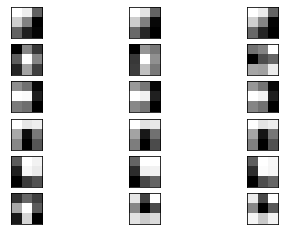

In [14]:
# retrieve weights from the second hidden layer
filters, biases = VGG16Net.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

### Test the Model with a Random Sample

In [17]:
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    O_image, y_label = element

# Note: each Keras Application expects a specific kind of input preprocessing. 
# For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs 
# before passing them to the model. vgg16.preprocess_input will convert the 
# input images from RGB to BGR, then will zero-center each color channel with 
# respect to the ImageNet dataset, without scaling.

P_image = tf.keras.applications.vgg16.preprocess_input(O_image)
X_image = tf.image.resize(P_image, [224,224], method='bilinear')
X_in = tf.expand_dims(X_image, axis=0)

print(O_image.shape, X_in.shape)

(320, 435, 3) (320, 435, 3) (1, 224, 224, 3)


Make Prediction

In [19]:
### START CODE HERE ###

p_pred = VGG16Net.predict(X_in)     # predict with the pre-trained model
label = tf.keras.applications.vgg16.decode_predictions(p_pred)      # decode the output of model

### END CODE HERE ###

print(p_pred.shape, tf.argmax(p_pred,axis=-1))

(1, 1000) tf.Tensor([701], shape=(1,), dtype=int64)
[[('n03888257', 'parachute', 0.8682085), ('n02782093', 'balloon', 0.028270502), ('n03908714', 'pencil_sharpener', 0.010583306), ('n03476684', 'hair_slide', 0.010232553), ('n07753592', 'banana', 0.00856376)]]


Show the Prediction Result

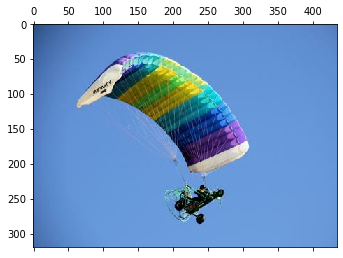

The prediction is parachute (86.82%)
The image class is  parachute


In [20]:
plt.matshow(O_image, fignum=None)
plt.show()

# retrieve the most likely result, e.g. highest probability
p_label = label[0][0]
# print the classification
print('The prediction is %s (%.2f%%)' % (p_label[1], p_label[2]*100) )
print('The image class is  ' + classes[y_label])

### Test the Model with a JPEG file

Use the following code cell to upload a local file to colab.<br>
If you are running this notebook in the local system, no need to execute the following code.

In [42]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:

    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

UnicodeDecodeError: ignored

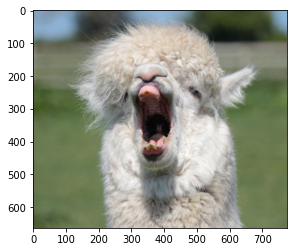

llama (49.23%)


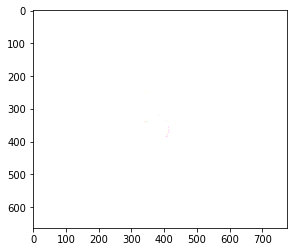

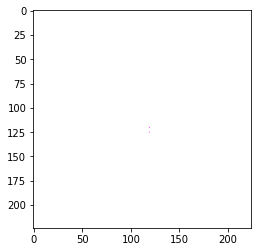

In [55]:
### START CODE HERE ###
from PIL import Image

# load an image from file using keras
in_image = Image.open('/content/drive/MyDrive/인적사항/짤/알파카.jpg')

# convert the image pixels to an array using keras
image = tf.keras.utils.img_to_array(in_image)

# reshape data format for the model input dimension
image = tf.image.resize(image, [224,224], method='bilinear')

# prepare the image for the VGG model
image = tf.expand_dims(tf.keras.applications.vgg16.preprocess_input(image), axis=0)

# predict the probability across all output classes
yhat = VGG16Net.predict(image)

# convert the probabilities to class labels
pred = tf.keras.applications.vgg16.decode_predictions(yhat)

# retrieve the most likely result, e.g. highest probability
label = pred[0][0]

### END CODE HERE ###

plt.imshow(in_image)
plt.show()

# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))